In [1]:
import torch
import torch_xla
import torch_xla.core.xla_model as xm

import pandas as pd
import numpy as np
import csv
import torch
import ctypes
import gc
import os

import dataset
import torch
import warnings

import pandas as pd
import numpy as np
import torch.nn as nn

from sklearn import metrics
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp

os.environ['PJRT_DEVICE'] = 'TPU' 
warnings.filterwarnings("ignore")
libc = ctypes.CDLL("libc.so.6")

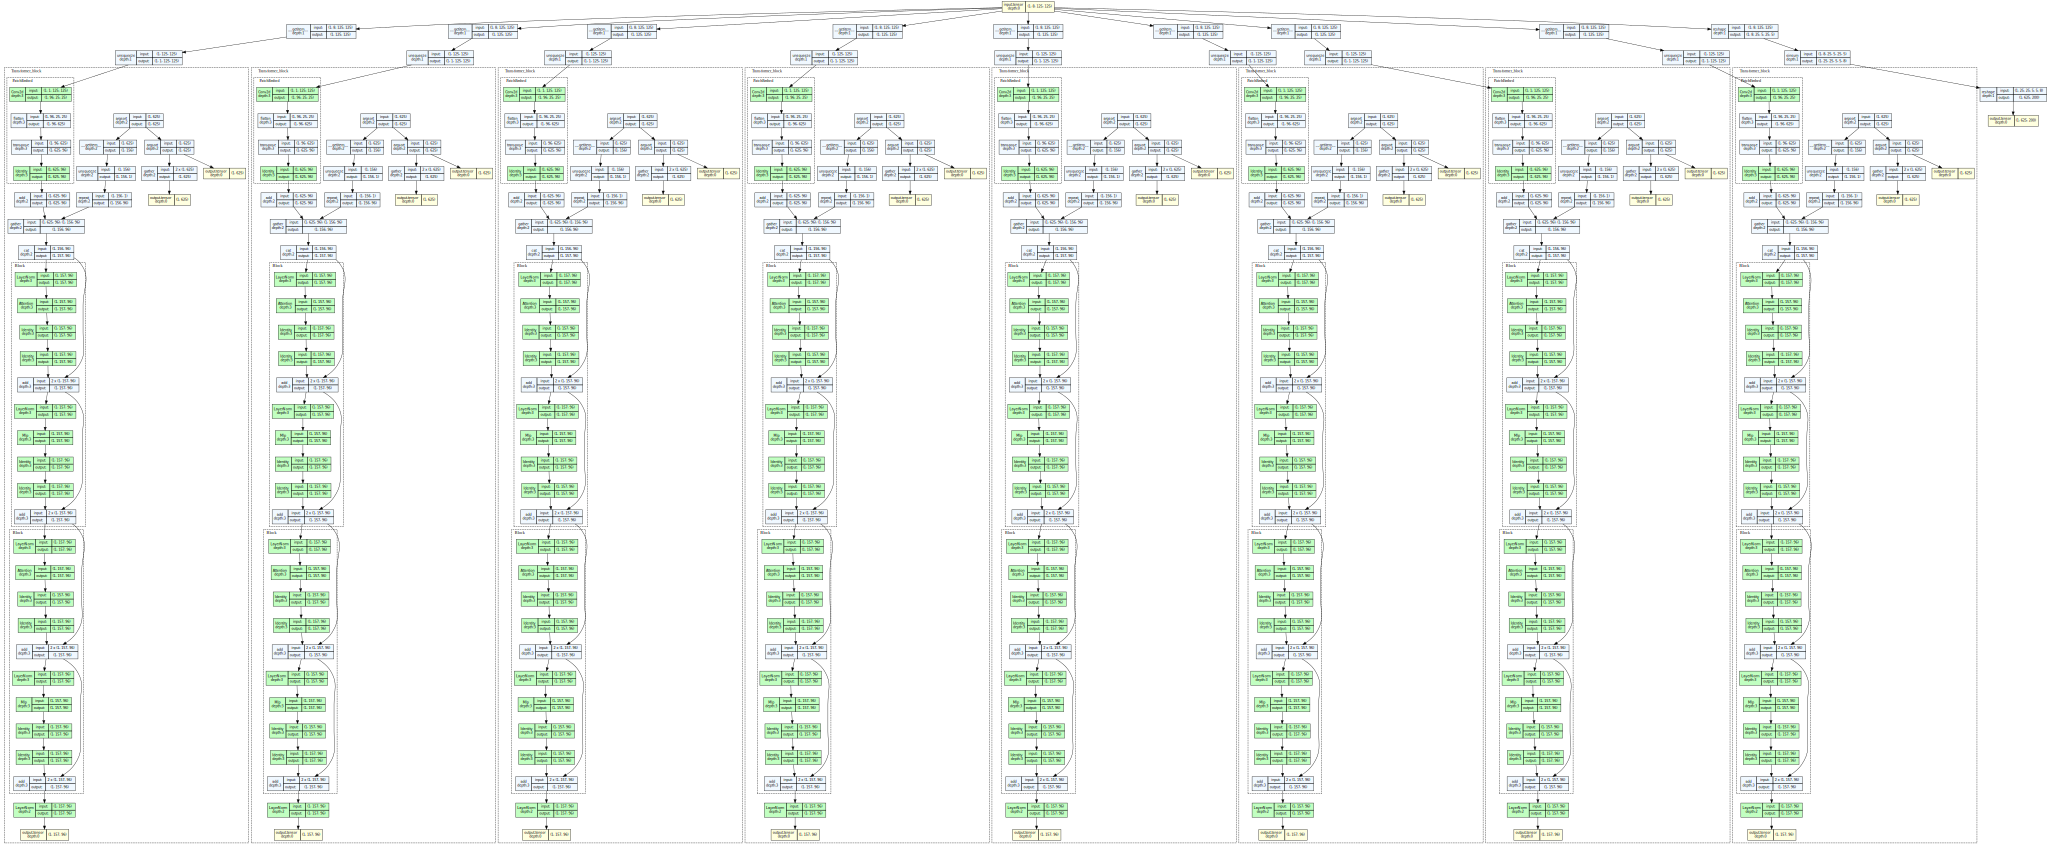

In [2]:
import numpy as np

import torch

def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype='float32')
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb
from functools import partial

import torch
import torch.nn as nn

from timm.models.vision_transformer import PatchEmbed, Block

class Transformer_block(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=8,
                 embed_dim=1024, depth=24, num_heads=16,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False):
        super().__init__()

        # --------------------------------------------------------------------------
        # MAE encoder specifics
        self.mask_ratio = 0.75
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(depth)])
        
        self.norm = norm_layer(embed_dim)

        self.initialize_weights()

    def initialize_weights(self):
        # initialization
        # initialize (and freeze) pos_embed by sin-cos embedding
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        # initialize patch_embed like nn.Linear (instead of nn.Conv2d)
        w = self.patch_embed.proj.weight.data
        torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        torch.nn.init.normal_(self.cls_token, std=.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)
    
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        
    def patchify(self, imgs):
        """
        imgs: (N, 8, H, W)
        x: (N, L, patch_size**2 *3)
        """
        p = self.patch_embed.patch_size[0]
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

        h = w = imgs.shape[2] // p
        x = imgs.reshape(shape=(imgs.shape[0], 8, h, p, w, p))
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 8))
        return x

    def unpatchify(self, x):
        """
        x: (N, L, patch_size**2 *3)
        imgs: (N, 8, H, W)
        """
        p = self.patch_embed.patch_size[0]
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]
        
        x = x.reshape(shape=(x.shape[0], h, w, p, p, 8))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 8, h * p, h * p))
        return imgs

    def random_masking(self, x, mask_ratio):
        """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))
        
        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]
        
        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore
    
    def forward(self, x):
        
#         imgs = self.patchify(x)

        
        # embed patches
        x = self.patch_embed(x)

        # add pos embed w/o cls token
        x = x + self.pos_embed[:, 1:, :]

        # masking: length -> length * mask_ratio
        x, mask, ids_restore = self.random_masking(x, self.mask_ratio)

        # append cls token
        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        
        return x, mask, ids_restore
    
class Encoder(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=8,
                 embed_dim=1024, depth=24, num_heads=16,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False):
        super().__init__()
        
        self.blocks = nn.ModuleList([
            Transformer_block(img_size=img_size, patch_size=patch_size, in_chans=1,
                 embed_dim=embed_dim, depth=depth, num_heads=num_heads,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False)
            for _ in range(8)
        ])
        
    def forward(self, x):
        encoded_tensor = []
        masks = []
        ids = []
        
        for i in range(8):
            img = x[:, i, :, :].unsqueeze(1)
            op, mask, ids_restore = self.blocks[i](img)
            encoded_tensor.append(op)
            masks.append(mask)
            ids.append(ids_restore)
            
        img = self.blocks[0].patchify(x)  # Assuming patchify is the same for all blocks
            
        return encoded_tensor, masks, ids, img

    
import torchvision
from torchview import draw_graph
from torchviz import make_dot
encoder = Encoder(
    img_size=125, patch_size=5, in_chans = 1,embed_dim=96, depth=2, num_heads=8,
    mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6))

model_graph = draw_graph(encoder, input_size=(1,8,125,125), expand_nested=True)
model_graph.visual_graph

In [3]:
class Decoder_transformer_block(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=8,
                 embed_dim=1024, depth=24, num_heads=16,
                 decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False):
        super().__init__()

        self.num_patches = (img_size//patch_size)**2
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)

        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))

        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, decoder_embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.decoder_blocks = nn.ModuleList([
            Block(decoder_embed_dim, decoder_num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(decoder_depth)])

        self.decoder_norm = norm_layer(decoder_embed_dim)
        self.decoder_pred = nn.Linear(decoder_embed_dim, patch_size**2 * 8, bias=True) # decoder to patch
        # --------------------------------------------------------------------------

        self.norm_pix_loss = norm_pix_loss

        self.initialize_weights()

    def initialize_weights(self):
        # initialization
        # initialize (and freeze) pos_embed by sin-cos embedding

        decoder_pos_embed = get_2d_sincos_pos_embed(self.decoder_pos_embed.shape[-1], int(self.num_patches**.5), cls_token=True)
        # print(decoder_pos_embed.shape)
        self.decoder_pos_embed.data.copy_(torch.from_numpy(decoder_pos_embed).float().unsqueeze(0))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        torch.nn.init.normal_(self.mask_token, std=.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def patchify(self, imgs):
        """
        imgs: (N, 8, H, W)
        x: (N, L, patch_size**2 *3)
        """
        p = self.patch_embed.patch_size[0]
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

        h = w = imgs.shape[2] // p
        x = imgs.reshape(shape=(imgs.shape[0], 8, h, p, w, p))
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 8))
        return x

    def unpatchify(self, x):
        """
        x: (N, L, patch_size**2 *3)
        imgs: (N, 8, H, W)
        """
        p = self.patch_embed.patch_size[0]
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]
        
        x = x.reshape(shape=(x.shape[0], h, w, p, p, 8))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 8, h * p, h * p))
        return imgs

    def forward(self, x):
        # embed tokens
        x = self.decoder_embed(x)

        # append mask tokens to sequence
#         mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
#         x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)  # no cls token
#         x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle
#         x =   # append cls token

        # add pos embed
        x = x + self.decoder_pos_embed

        # apply Transformer blocks
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)

        # predictor projection
        x = self.decoder_pred(x)

        # remove cls token
        x = x[:, 1:, :]

        return x
    
class Decoder(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=8,
             embed_dim=1024, depth=24, num_heads=16,
             decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
             mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False):
        super().__init__()
        
        self.block = Decoder_transformer_block(img_size=img_size, patch_size=patch_size, in_chans=in_chans,
                                                 embed_dim=embed_dim, depth=depth, num_heads=num_heads,
                                                 decoder_embed_dim=decoder_embed_dim, decoder_depth=decoder_depth, decoder_num_heads=decoder_num_heads,
                                                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False)
        
        self.mask_token = nn.Parameter(torch.zeros(1, 1, 96))
        
    def forward(self, x, ids):
        
        op = []
        cls_token = []
        for i in range(len(x)):
#             print(x[i].shape)
            mask_tokens = self.mask_token.repeat(x[i].shape[0], ids[i].shape[1] + 1 - x[i].shape[1], 1)
            x_ = torch.cat([x[i][:, 1:, :], mask_tokens], dim=1)  # no cls token
            cls_token.append(x[i][:,:1,:])
            x_ = torch.gather(x_, dim=1, index=ids[i].unsqueeze(-1).repeat(1, 1, x[i].shape[2]))  # unshuffle
            op.append(x_)
    
        op = torch.cat(op, axis = 2)
        cls_token = torch.cat(cls_token, axis = 2)
#         print(op.shape)
        op = torch.cat([cls_token, op], dim=1)
#         print(op.shape)
        op = self.block(op)
        return op

In [4]:
def get_sinusoid_encoding(num_tokens, token_len):
    """ Make Sinusoid Encoding Table

        Args:
            num_tokens (int): number of tokens
            token_len (int): length of a token
            
        Returns:
            (torch.FloatTensor) sinusoidal position encoding table
    """

    def get_position_angle_vec(i):
        return [i / np.power(10000, 2 * (j // 2) / token_len) for j in range(token_len)]

    sinusoid_table = np.array([get_position_angle_vec(i) for i in range(num_tokens)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2]) 

    return torch.FloatTensor(sinusoid_table).unsqueeze(0)

class FeatureDecoder(nn.Module):
    def __init__(self, latent_dim=768, depth=24, num_heads=16, 
                 embed_dim=512, mlp_ratio=4., num_patches=150,
                 norm_layer=nn.LayerNorm, output_latent_dim=256,
                 norm_pix_loss=False):
        super().__init__()
        self.num_patches = num_patches
        self.decoder_embed = nn.Linear(latent_dim, embed_dim, bias=True)
        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, self.num_patches, embed_dim), requires_grad=False)
        self.decoder_blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for _ in range(depth)])
        self.decoder_norm = norm_layer(embed_dim)
        self.decoder_pred = nn.Linear(embed_dim, output_latent_dim, bias=True)

        self.initialize_weights()

    def initialize_weights(self):
        decoder_pos_embed = get_sinusoid_encoding(self.num_patches, self.decoder_pos_embed.shape[-1])
        self.decoder_pos_embed.data.copy_(decoder_pos_embed)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward(self, x):
        x = self.decoder_embed(x)
        x = x + self.decoder_pos_embed
        for block in self.decoder_blocks:
            x = block(x)
        x = self.decoder_norm(x)
        x = self.decoder_pred(x)
        return x


In [5]:
from functools import partial

import torch
import torch.nn as nn

from timm.models.vision_transformer import PatchEmbed, Block

class Feature_Encoder(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=8,
                 embed_dim=1024, depth=24, num_heads=16,
                 decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False, output_latent_dim = 256):
        super().__init__()

        # --------------------------------------------------------------------------
        # MAE encoder specifics
        self.mask_ratio = 0.75
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(depth)])
        
        self.norm = norm_layer(embed_dim)
        self.projection = nn.Linear(in_features = embed_dim, out_features = output_latent_dim)

        self.initialize_weights()

    def initialize_weights(self):
        # initialization
        # initialize (and freeze) pos_embed by sin-cos embedding
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        # initialize patch_embed like nn.Linear (instead of nn.Conv2d)
        w = self.patch_embed.proj.weight.data
        torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        torch.nn.init.normal_(self.cls_token, std=.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)
    
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        
    def patchify(self, imgs):
        """
        imgs: (N, 8, H, W)
        x: (N, L, patch_size**2 *3)
        """
        p = self.patch_embed.patch_size[0]
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

        h = w = imgs.shape[2] // p
        x = imgs.reshape(shape=(imgs.shape[0], 8, h, p, w, p))
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 8))
        return x

    def unpatchify(self, x):
        """
        x: (N, L, patch_size**2 *3)
        imgs: (N, 8, H, W)
        """
        p = self.patch_embed.patch_size[0]
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]
        
        x = x.reshape(shape=(x.shape[0], h, w, p, p, 8))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 8, h * p, h * p))
        return imgs
        
    def random_masking(self, x, mask_ratio):
        """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))
        
        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]
        
        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore
    
    def forward(self, x):

        # embed patches
        x = self.patch_embed(x)

        # add pos embed w/o cls token
        x = x + self.pos_embed[:, 1:, :]

        # masking: length -> length * mask_ratio
        x, mask, ids_restore = self.random_masking(x, self.mask_ratio)
        
        # append cls token
        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        x = self.projection(x)

        return x

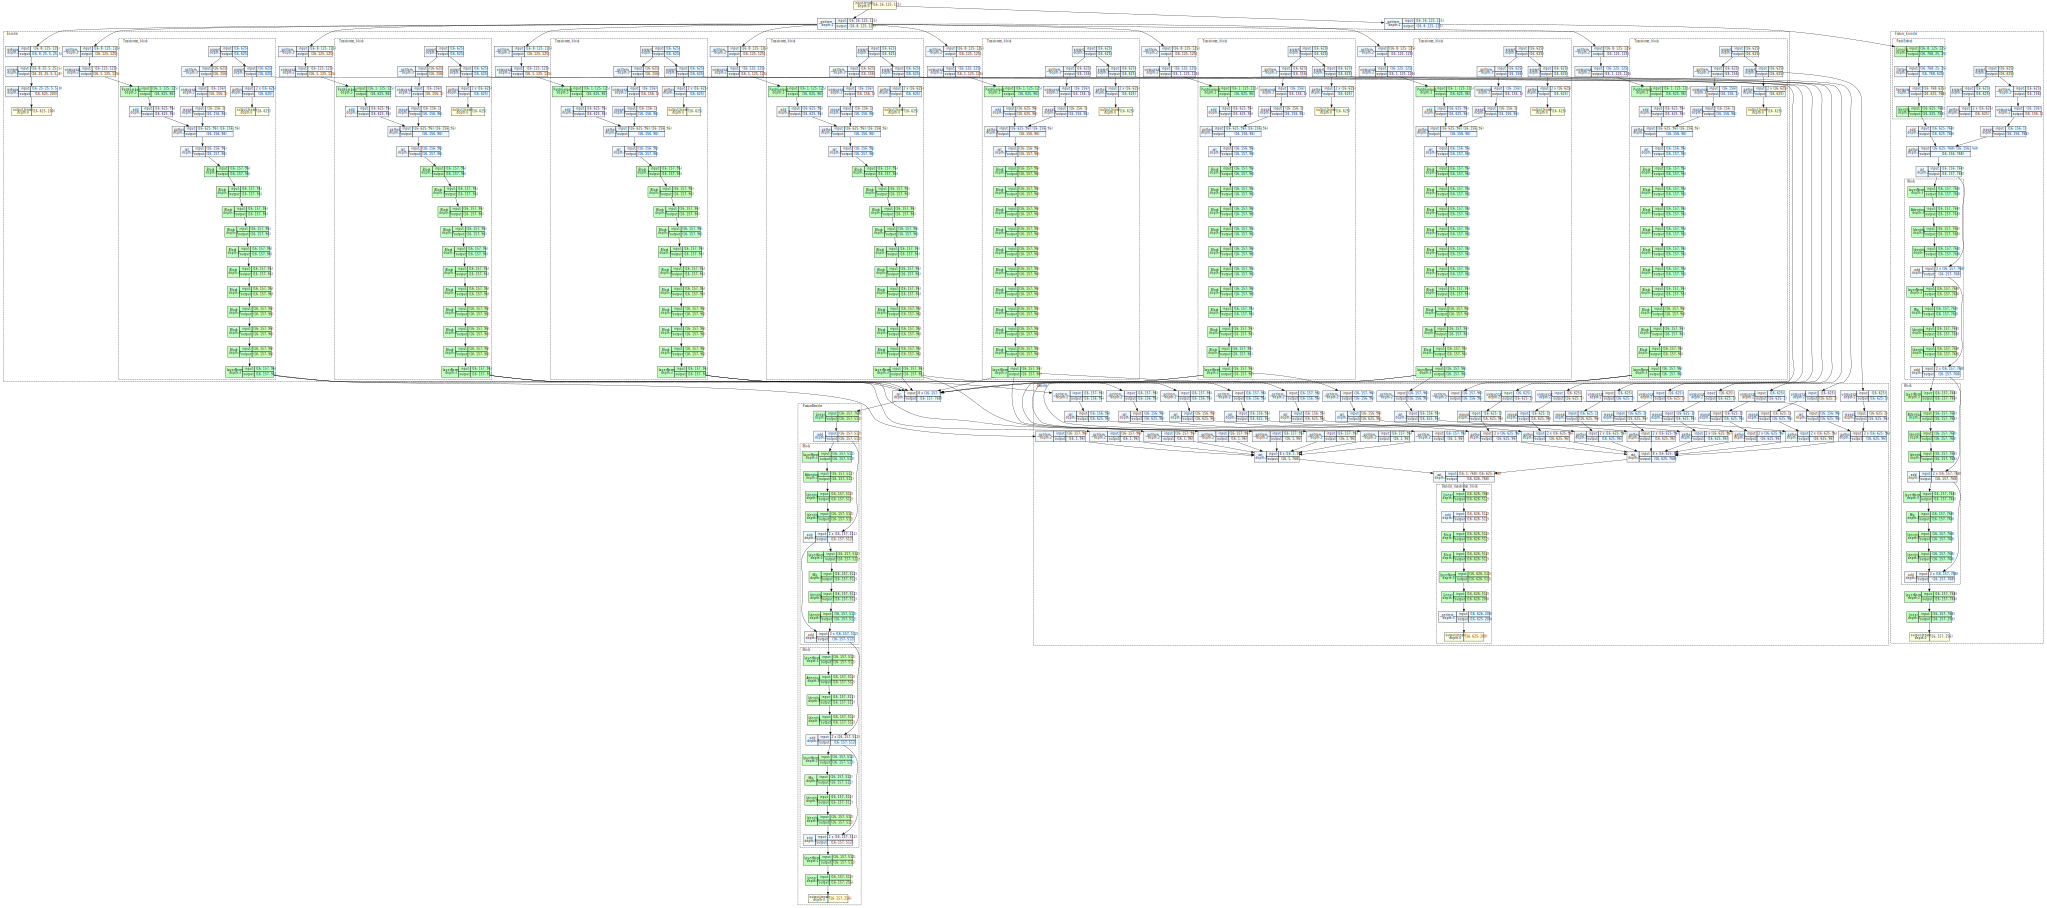

In [6]:
class Masked_VIT(nn.Module):
    def __init__(self, encoder, decoder, feature_decoder, feature_encoder, mask_ratio):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.feature_decoder = feature_decoder
        self.feature_encoder = feature_encoder
        self.mask_ratio = mask_ratio
        
    def forward(self, inp):
        batch_size, channels, height, width = inp.shape
        x = inp[:, :8, :, :]
        y = inp[:, 8:16, :, :]
        feature_encoded_output = self.feature_encoder(y)
        x, mask, ids_restore, img = self.encoder(x)
        concatenated_latent = torch.cat(x, axis = -1)
        pred = self.decoder(x, ids_restore)
        feature_decoded_output = self.feature_decoder(concatenated_latent)
        
        return pred, mask, img, feature_decoded_output, feature_encoded_output
    
def mae_vit_base_patch16_dec512d8b(img_size=125, mask_ratio = 0.75, patch_size = 5, **kwargs):
    encoder = Encoder(
        img_size=img_size, patch_size=5, embed_dim=96, depth=10, num_heads=8,in_chans = 1,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    
    decoder = Decoder(
        img_size=img_size, patch_size=5, embed_dim=768, depth=4, num_heads=8,in_chans = 1,
        decoder_embed_dim=512, decoder_depth=2, decoder_num_heads=16,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)

    feature_decoder = FeatureDecoder(latent_dim = 768, depth = 2, num_heads = 16, 
                                     embed_dim = 512, output_latent_dim = 256,
                                     num_patches = 157, )
    
    feature_encoder = Feature_Encoder(
        img_size=img_size, patch_size=5, embed_dim=768, depth=2, num_heads=12,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    
    model = Masked_VIT(encoder, decoder, feature_decoder, feature_encoder, mask_ratio)
    
    return model

# Instantiate the model
model = mae_vit_base_patch16_dec512d8b(img_size=125, mask_ratio = 0.75)
import torchvision
from torchview import draw_graph
from torchviz import make_dot

model_graph = draw_graph(model, input_size=(16,16,125,125), expand_nested=True)
model_graph.visual_graph

In [7]:
from tqdm import tqdm
import gc
from PIL import Image
X_Pretrain = []
for i in tqdm(range(10000)):
    with Image.open(f'/home/shashank/Extracted/0/{i+1}.png') as img:
        img_arr = np.array(img).reshape((125,125,8))
        X_Pretrain.append(img_arr)
        
    with Image.open(f'/home/shashank/Extracted/1/{i+1}.png') as img:
        img_arr = np.array(img).reshape((125,125,8))
        X_Pretrain.append(img_arr)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 510.55it/s]


In [8]:
length = len(X_Pretrain)
X_train = X_Pretrain[:int(0.8*length)]
X_test = X_Pretrain[int(0.8*length): int(length)]

In [9]:
X_train = np.array(X_train)
X_test = np.array(X_test)
# Initialize lists to hold means and stds for each channel
mean = []
std = []

# Calculate mean and std for each channel
for i in range(X_train.shape[-1]):  # Assuming the last dimension is the channel
    mean.append(X_train[:, :, :, i].mean())
    std.append(X_train[:, :, :, i].std())

# Normalize each channel
for i in range(X_train.shape[-1]):
    X_train[:, :, :, i] = (X_train[:, :, :, i] - mean[i]) / std[i]
    X_test[:, :, :, i] = (X_test[:, :, :, i] - mean[i]) / std[i]

# Perform zero suppression
X_train[X_train < 1e-3] = 0

In [10]:
import os
import torch
import pandas as pd
# from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

class Custom_Dataset(Dataset):
    def __init__(self, x, transform1, transform2):
        self.x = x
        self.transform1 = transform1
        self.transform2 = transform2
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_1 = (self.x[idx]).astype('float32')
        img_2 = img_1
        if self.transform1:
            img_1 = self.transform1(img_1)
            
        if self.transform2:
            img_2 = self.transform2(img_2)
            
        sample = {'img1' : img_1, 'img2' : img_2}
        
        return sample

In [11]:
transform1 = transforms.Compose([transforms.ToTensor()])
transform2 = transforms.Compose([transforms.ToTensor(),
                                 transforms.RandomAffine(degrees = 0, translate = (0.2, 0.2))])

dataset = Custom_Dataset(X_train, transform1 = transform1, transform2 = transform2)
sample = dataset.__getitem__(0)

print("X_train shape:", X_train.shape)
print("Sample image shape:", sample['img1'].shape)
print("Sample image values:", sample['img2'].shape)

X_train shape: (16000, 125, 125, 8)
Sample image shape: torch.Size([8, 125, 125])
Sample image values: torch.Size([8, 125, 125])


In [12]:
def reduce_fn(vals):
    # take average
    return sum(vals) / len(vals)

In [13]:
def train_one_epoch(model, train_dataloader, valid_dataloader, criterion, scheduler, device, optimizer):
    train_loss = []
    valid_loss = []

    model.train()
    scheduler.step()

    for step, batch in (enumerate(train_dataloader)):
        image1 = batch['img1'].to(device)
        image2 = batch['img2'].to(device)
        
        optimizer.zero_grad()
        img = torch.cat((image1, image2), axis = 1)
        outputs, ind, target, feature_decoded_output, feature_encoded_output = model(img)
        loss = criterion(target, outputs, ind, feature_decoded_output, feature_encoded_output)
        loss.backward()
        xm.optimizer_step(optimizer)
        
        if step%1000 == 0:
            xm.master_print(f'Train_Batch: {step}, loss: {loss.item()}')

        loss_reduced = xm.mesh_reduce('loss_reduce',loss,reduce_fn) 
        train_loss.append(loss_reduced.detach().cpu().numpy())
        gc.collect()

    model.eval()
    with torch.no_grad():
        for step, batch in (enumerate(valid_dataloader)):
            
            image1 = batch['img1'].to(device)
            image2 = batch['img2'].to(device)
            img = torch.cat((image1, image2), axis = 1)
            
            outputs, ind, target, feature_decoded_output, feature_encoded_output = model(img)
            loss = criterion(target, outputs, ind, feature_decoded_output, feature_encoded_output)
            
            loss_reduced = xm.mesh_reduce('loss_reduce',loss,reduce_fn) 
            valid_loss.append(loss_reduced.detach().cpu().numpy())
            
            if step%500 == 0:
                xm.master_print(f'Train_Batch: {step}, loss: {loss.item()}')
            gc.collect()

    return np.mean(train_loss), np.mean(valid_loss)

In [14]:
def data():
    ## Train dataset transformations
    train_transform1 = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip(),
                                transforms.RandomRotation(60),])
    
    train_transform2 = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip(),
                                transforms.RandomRotation(60),
                                transforms.RandomAffine(degrees = 0, translate = (0.2, 0.2))])

    ## Test dataset transformations
    test_transform = transforms.Compose([
                                transforms.ToTensor(),])

    ##Train Dataset
    train_dataset = Custom_Dataset(X_train, transform1 = train_transform1, transform2 = train_transform2)
    
    ##Test Dataset
    test_dataset = Custom_Dataset(X_test, transform1 = test_transform, transform2 = None)
    
    ##Sampler
    train_sampler = torch.utils.data.distributed.DistributedSampler(
                                                                    train_dataset,
                                                                    num_replicas=xm.xrt_world_size(),
                                                                    rank=xm.get_ordinal(),
                                                                    shuffle = True
                                                                    )
    
    ##Train Dataloader
    dataloader_train = torch.utils.data.DataLoader(train_dataset,
                                                    batch_size=64,
                                                    sampler = train_sampler,
                                                    drop_last = True,
                                                    num_workers=1,
                                                    pin_memory = True)
    
    
    ##Sampler
    valid_sampler = torch.utils.data.distributed.DistributedSampler(
                                                                    test_dataset,
                                                                    num_replicas=xm.xrt_world_size(),
                                                                    rank=xm.get_ordinal(),
                                                                    shuffle = False
                                                                    )
    ##Test Dataloader
    dataloader_test = torch.utils.data.DataLoader(test_dataset,
                                                  sampler = valid_sampler,
                                                  batch_size=64,
                                                  drop_last = True,
                                                  num_workers=1,
                                                 )
    return dataloader_train, dataloader_test

In [15]:
# import torch
# import numpy as np

# def custom_loss(imgs, pred, mask, feature_decoded_output, feature_encoded_output):
#     # Reconstruction Loss
#     tau = 1.5
#     imgs = imgs.reshape((imgs.shape[0], imgs.shape[1], 8, imgs.shape[2] // 8))
#     pred = pred.reshape((pred.shape[0], pred.shape[1], 8, pred.shape[2] // 8))

#     L = 0
#     for i in range(8):
#         l = ((pred[:, :, i, :] - imgs[:, :, i, :])**2).mean(dim=-1, keepdim=True)
#         mask_cpu = mask[i].unsqueeze(dim=-1)
#         loss = (l * mask_cpu).sum()
#         L += (loss / mask_cpu.sum())

#     # Contrastive Loss
#     L_C = 0
#     num_samples = imgs.shape[0]

#     maxx = feature_encoded_output.max()
#     maxxi = feature_decoded_output.max()
#     feature_encoded_output = (feature_encoded_output.view(num_samples, -1))/(maxx)
#     feature_decoded_output = (feature_decoded_output.view(num_samples, -1))/(maxxi)
    
    
#     dot_products = torch.matmul(feature_encoded_output, feature_decoded_output.T) / tau
#     exp_dot_products = torch.exp(dot_products)
#     # print(dot_products)
#     print(torch.exp(dot_products.max()))
#     for i in range(num_samples):
#         numerator = exp_dot_products[i, i]
#         denominator = exp_dot_products[i, :].sum()
#         L_C += -torch.log(numerator / denominator)

#     L_C /= num_samples
    
#     return L / 8 + L_C * 0.5

# # Example usage
# imgs = torch.randn(16, 625, 200)
# pred = torch.randn(16, 625, 200)
# mask = torch.randint(0, 2, (16, 625))
# feature_decoded_output = torch.rand((16, 157, 768))
# feature_encoded_output = torch.rand((16, 157, 768))
# tau = 0.5

# loss = custom_loss(imgs, pred, mask, feature_decoded_output, feature_encoded_output)
# print(loss)
import torch
import numpy as np

def custom_loss(imgs, pred, mask, feature_decoded_output, feature_encoded_output):
    # Reconstruction Loss
    tau = 1.5
    imgs = imgs.reshape((imgs.shape[0], imgs.shape[1], 8, imgs.shape[2] // 8))
    pred = pred.reshape((pred.shape[0], pred.shape[1], 8, pred.shape[2] // 8))

    L = 0
    for i in range(8):
        l = ((pred[:, :, i, :] - imgs[:, :, i, :])**2).mean(dim=-1, keepdim=True)
        mask_cpu = mask[i].unsqueeze(dim=-1)
        loss = (l * mask_cpu).sum()
        L += (loss / mask_cpu.sum())

    # Contrastive Loss
    L_C = 0
    num_samples = imgs.shape[0]

    feature_encoded_output = feature_encoded_output.view(num_samples, -1)
    feature_decoded_output = feature_decoded_output.view(num_samples, -1)
    
    # Normalize the feature vectors
    feature_encoded_output = feature_encoded_output / feature_encoded_output.norm(dim=1, keepdim=True)
    feature_decoded_output = feature_decoded_output / feature_decoded_output.norm(dim=1, keepdim=True)
    
    dot_products = torch.matmul(feature_encoded_output, feature_decoded_output.T) / tau
    
    # Log-Sum-Exp trick to avoid numerical instability
    max_dot_products = torch.max(dot_products, dim=1, keepdim=True)[0]
    exp_dot_products = torch.exp(dot_products - max_dot_products)
    
    for i in range(num_samples):
        numerator = exp_dot_products[i, i]
        denominator = exp_dot_products[i, :].sum()
        L_C += -torch.log(numerator / denominator)

    L_C /= num_samples
    
    return L / 8 + L_C * 0.5

# Example usage
imgs = torch.randn(16, 625, 200)
pred = torch.randn(16, 625, 200)
mask = torch.randint(0, 2, (16, 625))
feature_decoded_output = torch.rand((16, 157, 768))
feature_encoded_output = torch.rand((16, 157, 768))
tau = 0.5

loss = custom_loss(imgs, pred, mask, feature_decoded_output, feature_encoded_output)
print(loss)


tensor(33.3770)


In [ ]:

def train_function(model, epochs):
    criterion = custom_loss
    lr = 0.001
    num_train_steps = int(
        len(X_train) / 64 / xm.xrt_world_size() * epochs
    )

    lr = lr * xm.xrt_world_size()
    
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=0.05)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=num_train_steps
    )

    train_dataloader, test_dataloader = data()
    
    xm.master_print(f'num_training_steps = {num_train_steps}, world_size={xm.xrt_world_size()}')
    device = xm.xla_device()
    model = model.to(device)
    
    train_loss = []
    valid_loss = []
    for epoch in tqdm(range(epochs)):
        gc.collect()
        para_loader = pl.ParallelLoader(train_dataloader, [device])
        train_loader = para_loader.per_device_loader(device)

        val_loader = pl.ParallelLoader(test_dataloader, [device])
        valid_loader = val_loader.per_device_loader(device)
        
        trn_loss, val_loss = train_one_epoch(model, train_loader, valid_loader, criterion, scheduler, device, optimizer)
        
        scheduler.step()
        train_loss.append(trn_loss)
        valid_loss.append(val_loss)
        gc.collect()

        xm.master_print(f'Epoch {epoch+1}/{epochs}, Train Loss: {trn_loss:.4f}, Val Loss: {val_loss:.4f}')
        with open('losses.txt', 'a') as f:
            f.write(f'Epoch {epoch+1}/{epochs}, Train Loss: {trn_loss:.4f}, Val Loss: {val_loss:.4f}\n')
        
    xm.rendezvous('save_model')
    xm.master_print('save model')
    xm.save(model.state_dict(), f'./Model_files/xla_trained_model_epoch.pth')

def _mp_fn(rank, flags):
    try:
        model = mae_vit_base_patch16_dec512d8b(img_size=125, mask_ratio=0.75)
        dev = xm.xla_device()
        model = model.to(dev)
        dataloader_train, dataloader_test = data()
        torch.set_default_tensor_type('torch.FloatTensor')
        train_function(model, epochs=50)
        # xser.save(model.state_dict(), f"model.bin", master_only=True)
    except Exception as e:
        print(f"Exception in process {rank}: {e}")
        raise

if __name__ == '__main__':
    FLAGS = {}
    try:
        xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=8, start_method='fork')
    except Exception as e:
        print(f"Exception in main: {e}")

I0000 00:00:1718219551.132209  114550 pjrt_api.cc:100] GetPjrtApi was found for tpu at /home/shashank/.local/lib/python3.10/site-packages/libtpu/libtpu.so
I0000 00:00:1718219551.132214  114547 pjrt_api.cc:100] GetPjrtApi was found for tpu at /home/shashank/.local/lib/python3.10/site-packages/libtpu/libtpu.so
I0000 00:00:1718219551.132378  114550 pjrt_api.cc:79] PJRT_Api is set for device type tpu
I0000 00:00:1718219551.132379  114547 pjrt_api.cc:79] PJRT_Api is set for device type tpu
I0000 00:00:1718219551.132392  114547 pjrt_api.cc:146] The PJRT plugin has PJRT API version 0.46. The framework PJRT API version is 0.46.
I0000 00:00:1718219551.132392  114550 pjrt_api.cc:146] The PJRT plugin has PJRT API version 0.46. The framework PJRT API version is 0.46.
I0000 00:00:1718219551.135773  114551 pjrt_api.cc:100] GetPjrtApi was found for tpu at /home/shashank/.local/lib/python3.10/site-packages/libtpu/libtpu.so
I0000 00:00:1718219551.135891  114551 pjrt_api.cc:79] PJRT_Api is set for devic

num_training_steps = 1562, world_size=8



  0%|                                                                                                                               | 0/50 [00:00<?, ?it/s]

Train_Batch: 0, loss: 4.337015628814697
